**Mounting the drive.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Downloading the pre-processed data**
  * [Link](https://drive.google.com/file/d/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO/view?usp=sharing) to download the pre-processed data.
  * Added this data to drive and used it.
  
**Downloading the GloVe data**
 * This [site](https://nlp.stanford.edu/projects/glove/) was used to get GloVe data.
 * Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): [glove.42B.300d.zip](http://nlp.stanford.edu/data/glove.42B.300d.zip)

In [2]:
import os
d = "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/"
if not os.path.isfile(d+"glove.42B.300d.zip"):
    # https://stackoverflow.com/a/31667928/12005970
    !wget "http://nlp.stanford.edu/data/glove.42B.300d.zip" -O "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/glove.42B.300d.zip"
    !unzip "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/glove.42B.300d.zip"
else:
    !unzip "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/glove.42B.300d.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


**Importing libararies**

In [3]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from tqdm import tqdm
# https://stackoverflow.com/a/879249/12005970
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf 
import keras
from keras.layers import Input, Conv1D, Dense, Activation, LSTM, BatchNormalization, Dropout, concatenate, Embedding, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


**Reading and Splitting the data**
* Splitting the data into train(80%), CV (10%) and test (10%) dataset.

In [4]:
df = pd.read_csv(d+"Donor-Choose/preprocessed_data.csv")
print(df.shape)
df.head(2)

(109248, 9)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [5]:
X = df[[col for col in df.columns if col != 'project_is_approved']]
Y = df['project_is_approved']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42, stratify = Y)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size = 1/9, random_state = 42, stratify = y_train)
print('Total datapoints in data: {:,}\nDatapoints in train data: {:,}\nDatapoints in CV data: {:,}\nDatapoints in test data: {:,}'
     .format(df.shape[0], x_train.shape[0], x_cv.shape[0], x_test.shape[0]))
y_train, y_cv, y_test = y_train.values, y_cv.values, y_test.values

Total datapoints in data: 109,248
Datapoints in train data: 87,398
Datapoints in CV data: 10,925
Datapoints in test data: 10,925


# 1. Model 1

## 1.1 Pre-processing

### 1.1.1 Categrical Data

* `school_state`, `teacher_prefix` and `project_grade_category` features can gave only one category.
* After sorting (desceding order) the words based on frequency of each word, index each word. (Note: Indexing starts from 1).
* Other categorical features can more than 1 category in some datapoints, so datapoints can have different lenght, so we'll use padding (pre/post) to make them of same lenght.

**NOTE**: if word is not training data it'll be ignored

In [0]:
def return_dict(category):
    """Returns the dictionary with keys as words and values as index of word after sorting based on frequency of the word
    , number of unique words and maximum lenght"""
    
    word_freq = Counter()
    for state in x_train[category].values:
        word_freq.update(state.split())
    word_freq = dict(word_freq)
    word_freq = pd.DataFrame(list(word_freq.items()), columns = ['Word', 'Frequency'])

    # sorting by freqeuncy: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    word_freq = word_freq.sort_values(['Frequency'], axis = 0, ascending = False).reset_index(drop = True)
    word_freq['Id'] = range(1, word_freq.shape[0]+1)
    word_freq = word_freq[['Id', 'Word', 'Frequency']]

    # getting the maximum length:
    max_len = max([len(i.split(' ')) for i in x_train[category]])
    #getting the number of unique words in corresponding feature
    num_unique_word = word_freq.shape[0]

    # gettting the dictionary to encode the categories
    my_dict = dict(zip(word_freq['Word'].values, word_freq['Id'].values))
       
    return my_dict, num_unique_word, max_len
  
  
def encode_category(category_col, my_dict):
    """retruns encoded category"""
    lst = []
    for row in category_col:
        lst1 = []
        for word in row.split(' '):
            # if word is not training data it'll be ignored
            try:
                lst1.append(my_dict[word])
            except:
                continue
        lst.append(lst1)   
    return lst
  

def pad_category(category_col, my_dict, max_len, pad = 'post'):
    """returns padded category: default is post-padded"""
    lst = encode_category(category_col, my_dict)
    print('post padding to make each datapoit of same lenght = ', max_len)
    #https://keras.io/preprocessing/sequence/#pad_sequences
    lst = pad_sequences(lst, maxlen = max_len, padding = pad)
    return lst



def retrun_encoded_category(category_col, category):  
    """returns encoded category, each datapoint has same lenght for train, cv and test dataset.
    it also retruns the number of unique words in train data"""
    my_dict, num_unique_word, max_len = return_dict(category)
    
    lst1 = pad_category(x_train[category], my_dict, max_len)
    lst2 = pad_category(x_cv[category], my_dict, max_len)
    lst3 = pad_category(x_test[category], my_dict, max_len)
   
    print("Shape of train, cv and test {} features are: {}, {}, {}"
         .format(category, lst1.shape, lst2.shape, lst3.shape))
    
    return lst1, lst2, lst3, num_unique_word
  
#defining pretty table: http://zetcode.com/python/prettytable/

table = PrettyTable()
table.field_names = ['Model', "Train Loss", "Train AUC", "Test Loss", "Test AUC"]

In [56]:
print("Encoding the 'school_state' feature")
school_state_train, school_state_cv, school_state_test, len1 = retrun_encoded_category(x_train["school_state"].values,
                                                                              category = "school_state")

print("\nEncoding the 'teacher_prefix' feature")
teacher_prefix_train, teacher_prefix_cv, teacher_prefix_test, len2 = retrun_encoded_category(x_train["teacher_prefix"].values,
                                                                              category = "teacher_prefix")

print("\nEncoding the 'project_grade_category' feature")
project_grade_category_train, project_grade_category_cv, project_grade_category_test, len3 = retrun_encoded_category(x_train["project_grade_category"].values,
                                                                              category = "project_grade_category")

print("\nEncoding the 'clean_categories' feature")
clean_categories_train, clean_categories_cv, clean_categories_test, len4 = retrun_encoded_category(x_train["clean_categories"].values,
                                                                              category = "clean_categories")

print("\nEncoding the 'clean_subcategories' feature")
clean_subcategories_train, clean_subcategories_cv, clean_subcategories_test, len5 = retrun_encoded_category(x_train["clean_subcategories"].values,
                                                                              category = "clean_subcategories")

Encoding the 'school_state' feature
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
Shape of train, cv and test school_state features are: (87398, 1), (10925, 1), (10925, 1)

Encoding the 'teacher_prefix' feature
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
Shape of train, cv and test teacher_prefix features are: (87398, 1), (10925, 1), (10925, 1)

Encoding the 'project_grade_category' feature
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
post padding to make each datapoit of same lenght =  1
Shape of train, cv and test project_grade_category features are: (87398, 1), (10925, 1), (10925, 1)

Encoding the 'clean_categories' feature
post padding to make each datapoit of same lenght =  3
post 

### 1.1.2 Text Data

In [57]:
# pre-trained embedding: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
tokens = Tokenizer()
tokens.fit_on_texts(x_train["essay"].values)

# encoding text of essay features of train, cv and test data
encoded_essay_train = tokens.texts_to_sequences(x_train["essay"].values)
encoded_essay_cv    = tokens.texts_to_sequences(x_cv["essay"].values)
encoded_essay_test  = tokens.texts_to_sequences(x_test["essay"].values)

# gettting the length of unique words in train data, and adding (+1) becasue of zeros padding and words are encoded from 1 to n 
vocab_size1 = len(tokens.word_index) + 1

max_len_essay = 400 #max([len(i.split()) for i in x_train["essay"].values])
# padding the encoded data to make each datapoint of same dimension
encoded_essay_train = pad_sequences(encoded_essay_train, maxlen = max_len_essay, padding = 'post', truncating = 'post')
encoded_essay_cv    = pad_sequences(encoded_essay_cv, maxlen = max_len_essay, padding = 'post', truncating = 'post')
encoded_essay_test  = pad_sequences(encoded_essay_test, maxlen = max_len_essay, padding = 'post', truncating = 'post')

print("Shape of train, cv and test {} features are: {}, {}, {}"
         .format('essay', encoded_essay_train.shape, encoded_essay_cv.shape, encoded_essay_test.shape))

Shape of train, cv and test essay features are: (87398, 400), (10925, 400), (10925, 400)


In [9]:
def load_GloVe_vector(file_name):
    """retruns the vector representation of each word in dictionary format,
    words are as keys and vector representions are as values of keys"""
    with open(file_name, 'r') as f:
        glove_dict = dict()
        for line in tqdm(f):
            split_line = line.split() 
            # first element of split_line and word and rest is vector representation of corresponding word
            word = split_line[0]
            vector = np.array([float(i) for i in split_line[1:]])
            glove_dict[word] = vector
    print("\nGloVe is loaded. There are total {} words".format(len(glove_dict)))    
    return glove_dict

glove_dict = load_GloVe_vector('glove.42B.300d.txt') 

1917494it [03:21, 9500.52it/s]


GloVe is loaded. There are total 1917494 words


In [0]:
# below array will be used in Embedding layer
embedding_matrix1 = np.zeros((vocab_size1, 300), dtype = 'float32')
for word, index in tokens.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix1[index] = embedding_vector

### 1.1.3 Numerical Data

In [59]:
numerical_features_train = x_train[["teacher_number_of_previously_posted_projects", "price"]].values
numerical_features_cv    = x_cv[["teacher_number_of_previously_posted_projects", "price"]].values
numerical_features_test  = x_test[["teacher_number_of_previously_posted_projects", "price"]].values

std = StandardScaler()
numerical_features_train = std.fit_transform(numerical_features_train)
numerical_features_cv    = std.transform(numerical_features_cv)
numerical_features_test  = std.transform(numerical_features_cv)


print("Shape of numerical features: Train = {}, CV = {}, and Test = {}"
      .format(numerical_features_train.shape, numerical_features_cv.shape, numerical_features_test.shape))

Shape of numerical features: Train = (87398, 2), CV = (10925, 2), and Test = (10925, 2)


## 1.2 Training and Evaluation of model

**Architecture**
<img src= 'https://i.imgur.com/w395Yk9.png'>

**Source**: https://i.imgur.com/w395Yk9.png

In [0]:
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
  
def plot_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_auc = history.history['auc']
    val_auc = history.history['val_auc']

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (19, 6))
    ax1.plot(range(1, len(train_loss)+1), train_loss, label = 'Train Loss')
    ax1.plot(range(1, len(train_loss)+1), val_loss, label = 'CV Loss')
    ax1.set_title("Loss v/s #epochs", fontsize = 14)
    ax1.set_xlabel("#epochs", fontsize = 12)
    ax1.set_ylabel("binary-loss", fontsize = 12)
    ax1.legend(fontsize = 12)

    ax2.plot(range(1, len(train_auc)+1), train_auc, label = 'Train Loss')
    ax2.plot(range(1, len(train_auc)+1), val_auc, label = 'CV Loss')
    ax2.set_title("AUC v/s #epochs", fontsize = 14)
    ax2.set_xlabel("#epochs", fontsize = 12)
    ax2.set_ylabel("auc (area under the curve)", fontsize = 12)
    ax2.legend(fontsize = 12)

    plt.show()

In [0]:
#clearing the graph
keras.backend.clear_session()

# text input, max_len_essay
text_input = Input(shape = (encoded_essay_train.shape[1], ), name = 'Essay_text_input')
text_essay_embedding = Embedding(input_dim = vocab_size1, output_dim = 300, 
                                 weights=[embedding_matrix1], input_length = max_len_essay, 
                                 trainable = False, name = 'essay_embedding')(text_input)
#LSTM layer
lstm = LSTM(units = 150, dropout = 0.2, recurrent_dropout = 0.2, 
            kernel_regularizer = keras.regularizers.l2(0.001), return_sequences=True)(text_essay_embedding)
flatten1 = Flatten(name = 'flatten1')(lstm)

# school_state input
state_input = Input(shape = (school_state_train.shape[1], ), name = 'school_state')
state_embedding = Embedding(input_dim = len1, output_dim = 8, input_length = school_state_train.shape[1], 
                            name = 'school_state_embedding')(state_input)
flatten2 = Flatten(name = 'flatten2')(state_embedding)

# teacher_prefix input
teacher_prefix_input = Input(shape = (teacher_prefix_train.shape[1], ), name = 'teacher_prefix')
teacher_prefix_embedding = Embedding(input_dim = len2, output_dim = 2, input_length = teacher_prefix_train.shape[1], 
                            name = 'teacher_prefix_embedding')(teacher_prefix_input)
flatten3 = Flatten(name = 'flatten3')(teacher_prefix_embedding)

# project_grade_category input
project_grade_category_input = Input(shape = (project_grade_category_train.shape[1], ), name = 'project_grade_category')
project_grade_category_embedding = Embedding(input_dim = len3, output_dim = 2, input_length = project_grade_category_train.shape[1], 
                            name = 'project_grade_category_embedding')(project_grade_category_input)
flatten4 = Flatten(name = 'flatten4')(project_grade_category_embedding)

# clean_categories input
clean_categories_input = Input(shape = (clean_categories_train.shape[1], ), name = 'clean_categories')
clean_categories_embedding = Embedding(input_dim = len4, output_dim = 2, input_length = clean_categories_train.shape[1], 
                            name = 'clean_categories_embedding')(clean_categories_input)
flatten5 = Flatten(name = 'flatten5')(clean_categories_embedding)

# clean_subcategories input
clean_subcategories_input = Input(shape = (clean_subcategories_train.shape[1], ), name = 'clean_subcategories')
clean_subcategories_embedding = Embedding(input_dim = len5, output_dim = 4, input_length = clean_subcategories_train.shape[1], 
                            name = 'clean_subcategories_embedding')(clean_subcategories_input)
flatten6 = Flatten(name = 'flatten6')(clean_subcategories_embedding)

# numerical feature input
numerical_input = Input(shape = (numerical_features_train.shape[1], ), name = 'numerical_feature')
# dense layer
numerical_dens = Dense(units = 8, activation = 'relu', kernel_initializer = 'he_normal',
                       kernel_regularizer = keras.regularizers.l2(0.001), name = 'numerical_dense_layer')(numerical_input)

concat = concatenate(inputs = [flatten1, flatten2, flatten3, flatten4, flatten5, flatten6, numerical_dens], name = 'concatenation')

# Dense layer
X = Dense(units = 256, kernel_initializer = 'he_normal', 
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer_1')(concat)
X = BatchNormalization(name = 'BN_1')(X)
X = Activation('relu', name = 'activation1')(X)
X = Dropout(0.4, name = 'dropout1')(X)

# Dense layer
X = Dense(units = 128, kernel_initializer = 'he_normal',
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer_2')(X)
X = BatchNormalization(name = 'BN_2')(X)
X = Activation('relu', name = 'activation2')(X)
X = Dropout(0.4, name = 'dropout2')(X)

# Dense layer
X = Dense(units = 64, kernel_initializer = 'he_normal',
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer3')(X)
X = BatchNormalization(name = 'BN_3')(X)
X = Activation('relu', name = 'activartion3')(X)

#output layer
X = Dense(units = 1, activation = 'sigmoid',
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'output_layer')(X)

model = Model(inputs = [text_input, state_input, teacher_prefix_input, project_grade_category_input, clean_categories_input,
                        clean_subcategories_input, numerical_input], outputs = X, name = 'Model_1')
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Essay_text_input (InputLayer)   (None, 400)          0                                            
__________________________________________________________________________________________________
essay_embedding (Embedding)     (None, 400, 300)     15516600    Essay_text_input[0][0]           
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                 

**Reference**:
* For [early stopping and callback](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
* Keras [early stopping](https://keras.io/callbacks/#earlystopping) and [model check point](https://keras.io/callbacks/#modelcheckpoint)

In [0]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/#earlystopping
# https://keras.io/callbacks/#modelcheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 15, verbose = 1)
mc = ModelCheckpoint("Model_1.h5", monitor = "val_auc", mode = 'max', save_best_only = True, verbose = 1)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [auc])
history = model.fit([encoded_essay_train, school_state_train, teacher_prefix_train, 
                     project_grade_category_train, clean_categories_train, clean_subcategories_train,
                     numerical_features_train], y_train,
                    validation_data = ([encoded_essay_cv, school_state_cv, teacher_prefix_cv,
                                        project_grade_category_cv, clean_categories_cv,
                                        clean_subcategories_cv, numerical_features_cv], y_cv),
                    epochs = 100, batch_size = 1024, callbacks = [es, mc], verbose = 1)

# deleting the model
del model


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Train on 87398 samples, validate on 10925 samples
Epoch 1/100
87398/87398 [==============================] - 138s 2ms/step - loss: 1.3339 - auc: 0.5283 - val_loss: 0.8693 - val_auc: 0.5968

Epoch 00001: val_auc improved from -inf to

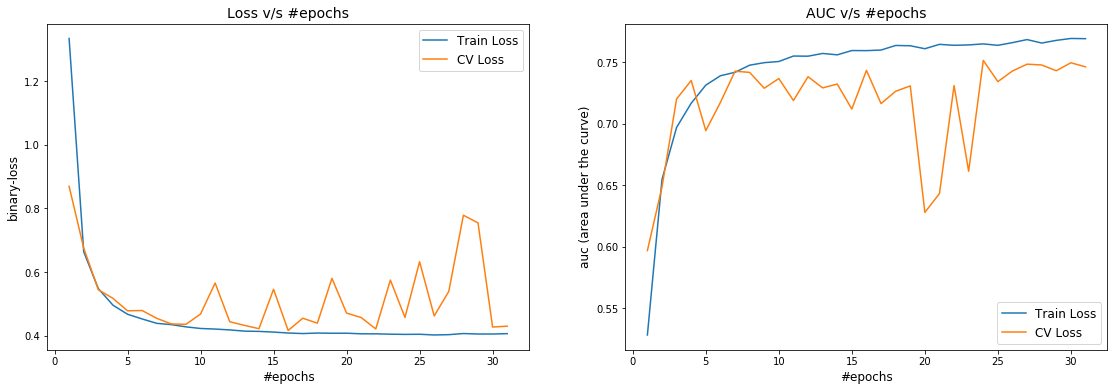

In [0]:
plot_history(history)

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
# custom metric error during loading the model:  # https://github.com/keras-team/keras/issues/5916#issuecomment-300038263
print("\nLoadingg the model..")
if os.path.isfile(d+"Donor-Choose/Model_1.h5"):
    model1 = load_model(d+"Donor-Choose/Model_1.h5", custom_objects = {"auc": auc})
else:
    #move the saved model to dirve
    !cp "/content/Model_1.h5" "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/Donor-Choose"
    model1 = load_model("Model_1.h5", custom_objects = {"auc":auc})
    

print("Evaluating model...")
print("For train data...")
score1 = model1.evaluate([encoded_essay_train, school_state_train, teacher_prefix_train, 
                     project_grade_category_train, clean_categories_train, clean_subcategories_train,
                     numerical_features_train], y_train, batch_size = 512)

print("For test data...")
score2 = model1.evaluate([encoded_essay_test, school_state_test, teacher_prefix_test, 
                     project_grade_category_test, clean_categories_test, clean_subcategories_test,
                     numerical_features_test], y_test, batch_size = 512)
print("\nFor training data: Loss = {:.4} and AUC = {:.4}\nFor test data: Loss = {:.4} and AUC = {:.4}"
      .format(score1[0], score1[1], score2[0], score2[1]))
table.add_row(["Model 1", round(score1[0], 4), round(score1[1], 4), round(score2[0], 4), round(score2[1], 4)])


Loadingg the model..
Evaluating model...
For train data...
87398/87398 [==============================] - 71s 814us/step
For test data...
10925/10925 [==============================] - 9s 811us/step

For training data: Loss = 0.4431 and AUC = 0.7833
For test data: Loss = 0.4835 and AUC = 0.7536


# Model 2

## 2.1 Pre-processing

### 2.1.1 Text data (`essay` feature)

**Note:** Selecting only those words which have **idf score value inbetween 2 and 11.**

Number of tokens in training data:  51685
IDF scores are:
1st quantile   = 1.0079146235593675 (minimum)
25th quantile  = 9.670188918828364
50th quantile  = 11.279626831262464 (median)
75th qunatile  = 11.685091939370627
100th quantile = 11.685091939370627 (maximum)


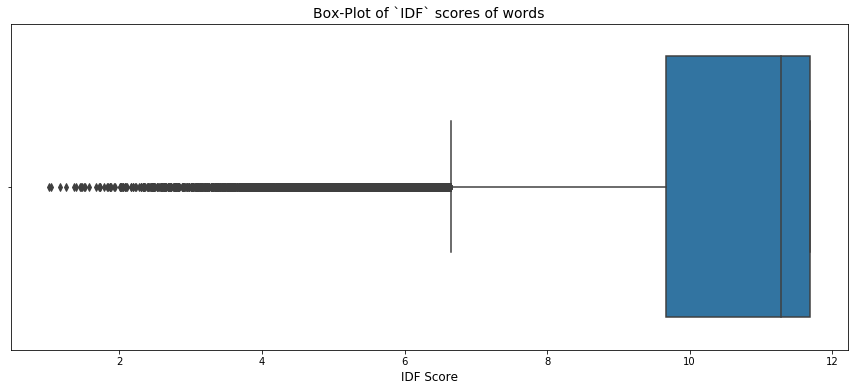

Number of tokens after dropping the tokens which have very high and very low idf score:  25503


In [64]:
tfidf = TfidfVectorizer()
tfidf.fit(x_train["essay"].values)

df1 = pd.DataFrame(data = [[i, j] for i, j in zip(tfidf.get_feature_names(), tfidf.idf_)], columns = ["word", "idf"])
print("Number of tokens in training data: ", df1.shape[0])
print("IDF scores are:\n1st quantile   = {} (minimum)\n\
25th quantile  = {}\
\n50th quantile  = {} (median)\n\
75th qunatile  = {}\n\
100th quantile = {} (maximum)"
      .format(np.quantile(df1["idf"].values, 0), 
              np.quantile(df1["idf"].values, 0.25),
              np.quantile(df1["idf"].values, 0.50),
              np.quantile(df1["idf"].values, 0.75),
              np.quantile(df1["idf"].values, 1)))

plt.figure(figsize = (15, 6))
sns.boxplot(x = "idf", data = df1)
plt.title("Box-Plot of `IDF` scores of words", fontsize = 14)
plt.xlabel('IDF Score', fontsize = 12)
plt.show()

#selecting the words whoose idf score is IQR range
df1 = df1[(df1["idf"] >= 2) & (df1["idf"] <= 11)]
vocab_size2 = df1.shape[0]+1
print("Number of tokens after dropping the tokens which have very high and very low idf score: ", df1.shape[0])

In [65]:
df1 = df1.sort_values(["idf"], ascending = False).reset_index(drop = True)
df1["index"] = range(1, df1.shape[0]+1)
vocab_dict = dict(zip(df1["word"], df1["index"]))
df1 = df1[["index", "word", "idf"]]
df1.head()

,index,word,idf
0,1,zusak,10.991945
1,2,burch,10.991945
2,3,naea,10.991945
3,4,nacho,10.991945
4,5,nable,10.991945


In [66]:
def return_text_encode(essays, vocab_dict):
    lst1 = []
    for essay in essays:
        lst = []
        for word in essay.split():
            try:
                lst.append(vocab_dict[word])
            except:
                continue
        lst1.append(lst)
    max_len_text = max([len(i) for i in lst1])
    return lst1, max_len_text


def encode_text_same_dimension():
    lst1, max_len_text = return_text_encode(x_train["essay"].values, vocab_dict)
    print("maximum length of essay in train data is {}, but I'm taking {} as deafult".format(max_len_text, 300))
    max_len_text = 300
    lst2, _ = return_text_encode(x_cv["essay"].values, vocab_dict)
    lst3, _ = return_text_encode(x_test["essay"].values, vocab_dict)
    
    lst1 = pad_sequences(lst1, maxlen = max_len_text, padding = 'post', truncating = 'post')
    lst2 = pad_sequences(lst2, maxlen = max_len_text, padding = 'post', truncating = 'post')
    lst3 = pad_sequences(lst3, maxlen = max_len_text, padding = 'post', truncating = 'post')
    
    return lst1, lst2, lst3, max_len_text
  
encoded_essay_train, encoded_essay_cv, encoded_essay_test, max_len_text = encode_text_same_dimension()
print("Shape of train, cv and test data are: {}, {} and {}".format(encoded_essay_train.shape, 
                                                                   encoded_essay_cv.shape, encoded_essay_test.shape))

maximum length of essay in train data is 294, but I'm taking 300 as deafult
Shape of train, cv and test data are: (87398, 300), (10925, 300) and (10925, 300)


In [0]:
# below array will be used in Embedding layer
embedding_matrix2 = np.zeros((vocab_size2, 300), dtype = 'float32')
for word, index in vocab_dict.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix2[index] = embedding_vector

## 2.2 Model Trainin and Evaluating

In [68]:
#clearing the graph
keras.backend.clear_session()

# text input, max_len_essay
text_input = Input(shape = (encoded_essay_train.shape[1], ), name = 'Essay_text_input')
text_essay_embedding = Embedding(input_dim = vocab_size2, output_dim = 300, 
                                 weights=[embedding_matrix2], input_length = max_len_text, 
                                 trainable = False, name = 'essay_embedding')(text_input)
#LSTM layer
lstm = LSTM(units = 150, dropout = 0.2, recurrent_dropout = 0.2, 
             kernel_regularizer = keras.regularizers.l2(0.001), return_sequences=True)(text_essay_embedding)
flatten1 = Flatten(name = 'flatten1')(lstm)

# school_state input
state_input = Input(shape = (school_state_train.shape[1], ), name = 'school_state')
state_embedding = Embedding(input_dim = len1, output_dim = 8, input_length = school_state_train.shape[1], 
                            name = 'school_state_embedding')(state_input)
flatten2 = Flatten(name = 'flatten2')(state_embedding)

# teacher_prefix input
teacher_prefix_input = Input(shape = (teacher_prefix_train.shape[1], ), name = 'teacher_prefix')
teacher_prefix_embedding = Embedding(input_dim = len2, output_dim = 2, input_length = teacher_prefix_train.shape[1], 
                            name = 'teacher_prefix_embedding')(teacher_prefix_input)
flatten3 = Flatten(name = 'flatten3')(teacher_prefix_embedding)

# project_grade_category input
project_grade_category_input = Input(shape = (project_grade_category_train.shape[1], ), name = 'project_grade_category')
project_grade_category_embedding = Embedding(input_dim = len3, output_dim = 2, input_length = project_grade_category_train.shape[1], 
                            name = 'project_grade_category_embedding')(project_grade_category_input)
flatten4 = Flatten(name = 'flatten4')(project_grade_category_embedding)

# clean_categories input
clean_categories_input = Input(shape = (clean_categories_train.shape[1], ), name = 'clean_categories')
clean_categories_embedding = Embedding(input_dim = len4, output_dim = 2, input_length = clean_categories_train.shape[1], 
                            name = 'clean_categories_embedding')(clean_categories_input)
flatten5 = Flatten(name = 'flatten5')(clean_categories_embedding)

# clean_subcategories input
clean_subcategories_input = Input(shape = (clean_subcategories_train.shape[1], ), name = 'clean_subcategories')
clean_subcategories_embedding = Embedding(input_dim = len5, output_dim = 4, input_length = clean_subcategories_train.shape[1], 
                            name = 'clean_subcategories_embedding')(clean_subcategories_input)
flatten6 = Flatten(name = 'flatten6')(clean_subcategories_embedding)

# numerical feature input
numerical_input = Input(shape = (numerical_features_train.shape[1], ), name = 'numerical_feature')
# dense layer
numerical_dens = Dense(units = 8, activation = 'relu', kernel_initializer = 'he_normal', 
                        kernel_regularizer = keras.regularizers.l2(0.001), name = 'numerical_dense_layer')(numerical_input)

concat = concatenate(inputs = [flatten1, flatten2, flatten3, flatten4, flatten5, flatten6, numerical_dens], name = 'concatenation')

# Dense layer
X = Dense(units = 256, kernel_initializer = 'he_normal', 
           kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer_1')(concat)
X = BatchNormalization(name = 'BN_1')(X)
X = Activation('relu', name = 'activation1')(X)
X = Dropout(0.4, name = 'dropout1')(X)

# Dense layer
X = Dense(units = 128, kernel_initializer = 'he_normal',
           kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer_2')(X)
X = BatchNormalization(name = 'BN_2')(X)
X = Activation('relu', name = 'activation2')(X)
X = Dropout(0.4, name = 'dropout2')(X)

# Dense layer
X = Dense(units = 64, kernel_initializer = 'he_normal', 
           kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_layer3')(X)
X = BatchNormalization(name = 'BN_3')(X)
X = Activation('relu', name = 'activartion3')(X)

#output layer
X = Dense(units = 1, activation = 'sigmoid', 
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'output_layer')(X)

model2 = Model(inputs = [text_input, state_input, teacher_prefix_input, project_grade_category_input, clean_categories_input,
                        clean_subcategories_input, numerical_input], outputs = X, name = 'Model_2')
print(model2.summary())

Model: "Model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Essay_text_input (InputLayer)   (None, 300)          0                                            
__________________________________________________________________________________________________
essay_embedding (Embedding)     (None, 300, 300)     7651200     Essay_text_input[0][0]           
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
____________________________________________________________________________________________

In [69]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 15, verbose = 1)
mc = ModelCheckpoint("Model_2.h5", monitor = "val_auc", mode = 'max', save_best_only = True, verbose = 1)
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [auc])

history = model2.fit([encoded_essay_train, school_state_train, teacher_prefix_train, 
                     project_grade_category_train, clean_categories_train, clean_subcategories_train,
                     numerical_features_train], y_train,
                    validation_data = ([encoded_essay_cv, school_state_cv, teacher_prefix_cv,
                                        project_grade_category_cv, clean_categories_cv,
                                        clean_subcategories_cv, numerical_features_cv], y_cv),
                    epochs = 100, batch_size = 1024, callbacks = [es, mc],verbose = 1)
del model2

Train on 87398 samples, validate on 10925 samples
Epoch 1/100
87398/87398 [==============================] - 101s 1ms/step - loss: 1.1347 - auc: 0.6151 - val_loss: 0.7976 - val_auc: 0.6800

Epoch 00001: val_auc improved from -inf to 0.67999, saving model to Model_2.h5
Epoch 2/100
87398/87398 [==============================] - 98s 1ms/step - loss: 0.6753 - auc: 0.6814 - val_loss: 0.6424 - val_auc: 0.7045

Epoch 00002: val_auc improved from 0.67999 to 0.70449, saving model to Model_2.h5
Epoch 3/100
87398/87398 [==============================] - 98s 1ms/step - loss: 0.5718 - auc: 0.7027 - val_loss: 0.5444 - val_auc: 0.7146

Epoch 00003: val_auc improved from 0.70449 to 0.71455, saving model to Model_2.h5
Epoch 4/100
87398/87398 [==============================] - 98s 1ms/step - loss: 0.5130 - auc: 0.7209 - val_loss: 0.4891 - val_auc: 0.7286

Epoch 00004: val_auc improved from 0.71455 to 0.72861, saving model to Model_2.h5
Epoch 5/100
87398/87398 [==============================] - 98s 1ms/s

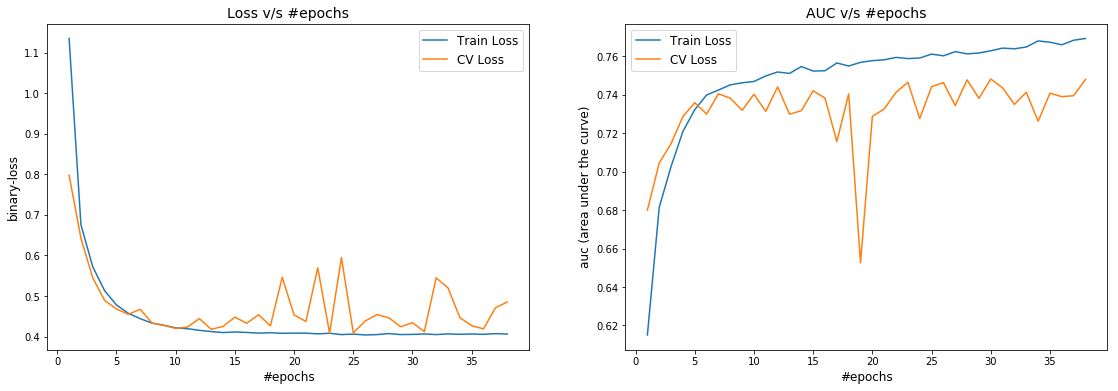

In [70]:
plot_history(history)

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# custom metric error during loading the model
print("\nLoadingg the model..")

if os.path.isfile(d+"Donor-Choose/Model_2.h5"):
    model2 = load_model(d+"Donor-Choose/Model_2.h5", custom_objects = {"auc": auc})
else:
    #move the saved model to dirve
    !cp "/content/Model_2.h5" "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/Donor-Choose"
    model2 = load_model("Model_2.h5", custom_objects = {"auc":auc})
    
print("Evaluating model...")
print("For train data...")
score1 = model2.evaluate([encoded_essay_train, school_state_train, teacher_prefix_train, 
                     project_grade_category_train, clean_categories_train, clean_subcategories_train,
                     numerical_features_train], y_train, batch_size = 512)

print("For test data...")
score2 = model2.evaluate([encoded_essay_test, school_state_test, teacher_prefix_test, 
                     project_grade_category_test, clean_categories_test, clean_subcategories_test,
                     numerical_features_test], y_test, batch_size = 512)

print("\nFor training data: Loss = {:.4} and AUC = {:.4}\nFor test data: Loss = {:.4} and AUC = {:.4}"
      .format(score1[0], score1[1], score2[0], score2[1]))
table.add_row(["Model 2", round(score1[0], 4), round(score1[1], 4), round(score2[0], 4), round(score2[1], 4)])


Loadingg the model..
Evaluating model...
For train data...
87398/87398 [==============================] - 54s 613us/step
For test data...
10925/10925 [==============================] - 7s 618us/step

For training data: Loss = 0.4178 and AUC = 0.7868
For test data: Loss = 0.4641 and AUC = 0.7377


# 3. Model 3

**Architecture**

<img src = "https://i.imgur.com/Q2qVPld.jpg">

Source: appliedaicourse.com


## 3.1 Text data

In [73]:
# pre-trained embedding: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
tokens = Tokenizer()
tokens.fit_on_texts(x_train["essay"].values)

# encoding text of essay features of train, cv and test data
encoded_essay_train = tokens.texts_to_sequences(x_train["essay"].values)
encoded_essay_cv    = tokens.texts_to_sequences(x_cv["essay"].values)
encoded_essay_test  = tokens.texts_to_sequences(x_test["essay"].values)

# gettting the length of unique words in train data, and adding (+1) becasue of zeros padding and words are encoded from 1 to n 
vocab_size1 = len(tokens.word_index) + 1

max_len_essay = 400 #max([len(i.split()) for i in x_train["essay"].values])
# padding the encoded data to make each datapoint of same dimension
encoded_essay_train = pad_sequences(encoded_essay_train, maxlen = max_len_essay, padding = 'post', truncating = 'post')
encoded_essay_cv    = pad_sequences(encoded_essay_cv, maxlen = max_len_essay, padding = 'post', truncating = 'post')
encoded_essay_test  = pad_sequences(encoded_essay_test, maxlen = max_len_essay, padding = 'post', truncating = 'post')

print("Shape of train, cv and test {} features are: {}, {}, {}"
         .format('essay', encoded_essay_train.shape, encoded_essay_cv.shape, encoded_essay_test.shape))

# below array will be used in Embedding layer
embedding_matrix1 = np.zeros((vocab_size1, 300), dtype = 'float32')
for word, index in tokens.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix1[index] = embedding_vector

Shape of train, cv and test essay features are: (87398, 400), (10925, 400), (10925, 400)


## 3.2 Other than text data

### 3.2.1 Categorical Features

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

#school_state feature
school_state_train = vectorizer.fit_transform(x_train['school_state'].values)
school_state_cv    = vectorizer.transform(x_cv['school_state'].values)
school_state_test  = vectorizer.transform(x_test['school_state'].values)
print("Shape of school_state after one-hot encoding: Train = {}, CV = {}, Test = {}"
      .format(school_state_train.shape, school_state_cv.shape, school_state_test.shape))

# teacher_prefix
teacher_prefix_train = vectorizer.fit_transform(x_train['teacher_prefix'].values)
teacher_prefix_cv    = vectorizer.transform(x_cv['teacher_prefix'].values)
teacher_prefix_test  = vectorizer.transform(x_test['teacher_prefix'].values)
print("Shape of teacher_prefix after one-hot encoding: Train = {}, CV = {}, Test = {}"
      .format(teacher_prefix_train.shape, teacher_prefix_cv.shape, teacher_prefix_test.shape))

# project_grade_category
project_grade_category_train = vectorizer.fit_transform(x_train['project_grade_category'].values)
project_grade_category_cv    = vectorizer.transform(x_cv['project_grade_category'].values)
project_grade_category_test  = vectorizer.transform(x_test['project_grade_category'].values)
print("Shape of project_grade_category after one-hot encoding: Train = {}, CV = {}, Test = {}"
      .format(project_grade_category_train.shape, project_grade_category_cv.shape, project_grade_category_test.shape))

# clean_categories
clean_categories_train = vectorizer.fit_transform(x_train['clean_categories'].values)
clean_categories_cv    = vectorizer.transform(x_cv['clean_categories'].values)
clean_categories_test  = vectorizer.transform(x_test['clean_categories'].values)
print("Shape of clean_categories after one-hot encoding: Train = {}, CV = {}, Test = {}"
      .format(clean_categories_train.shape, clean_categories_cv.shape, clean_categories_test.shape))

# clean_subcategories
clean_subcategories_train = vectorizer.fit_transform(x_train['clean_subcategories'].values)
clean_subcategories_cv    = vectorizer.transform(x_cv['clean_subcategories'].values)
clean_subcategories_test  = vectorizer.transform(x_test['clean_subcategories'].values)
print("Shape of clean_subcategories after one-hot encoding: Train = {}, CV = {}, Test = {}"
      .format(clean_subcategories_train.shape, clean_subcategories_cv.shape, clean_subcategories_test.shape))

Shape of school_state after one-hot encoding: Train = (87398, 51), CV = (10925, 51), Test = (10925, 51)
Shape of teacher_prefix after one-hot encoding: Train = (87398, 5), CV = (10925, 5), Test = (10925, 5)
Shape of project_grade_category after one-hot encoding: Train = (87398, 4), CV = (10925, 4), Test = (10925, 4)
Shape of clean_categories after one-hot encoding: Train = (87398, 9), CV = (10925, 9), Test = (10925, 9)
Shape of clean_subcategories after one-hot encoding: Train = (87398, 30), CV = (10925, 30), Test = (10925, 30)


### 3.2.2 Numerical Features

In [75]:
print("Shape of numerical features: Train = {}, CV = {}, and Test = {}"
      .format(numerical_features_train.shape, numerical_features_cv.shape, numerical_features_test.shape))

Shape of numerical features: Train = (87398, 2), CV = (10925, 2), and Test = (10925, 2)


### 3.2.3 Concatenating Non-text data

In [76]:
print("There are {} dimensions in school_state, {} dimensions in teacher_prefix,\n\
      {} dimensions in project_grade_category, {} dimensions in clean_categories,\n\
      {} dimensions in clean_subcategories and {} dimensions in numerical feature\n\
      So there will total {} features after concatenation."
      .format(school_state_cv.shape[1], teacher_prefix_cv.shape[1], project_grade_category_cv.shape[1],
             clean_categories_cv.shape[1], clean_subcategories_cv.shape[1], numerical_features_cv.shape[1],
              (school_state_cv.shape[1]  + teacher_prefix_cv.shape[1] + project_grade_category_cv.shape[1] 
               + clean_categories_cv.shape[1] + clean_subcategories_cv.shape[1]+numerical_features_cv.shape[1])))

# concatenating sparse and dense matrix:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html
non_text_train = scipy.sparse.hstack([school_state_train, teacher_prefix_train, 
                                      project_grade_category_train, clean_categories_train,
                                      clean_subcategories_train, numerical_features_train])

non_text_cv = scipy.sparse.hstack([school_state_cv, teacher_prefix_cv, 
                                      project_grade_category_cv, clean_categories_cv,
                                      clean_subcategories_cv, numerical_features_cv])

non_text_test = scipy.sparse.hstack([school_state_test, teacher_prefix_test, 
                                      project_grade_category_test, clean_categories_test,
                                      clean_subcategories_test, numerical_features_test])

print("Shape of non_text data: Train = {}, CV = {} and Test = {}".format(non_text_train.shape,
                                                                        non_text_cv.shape, non_text_test.shape))

print("\nAfter converting sparse to dense and changing the shape of non_text data")
# scipy.sparse.coo.coo_matrix to dense matrix and then changing the shape of
# so that data is compatble with Conv1D
non_text_train = non_text_train.toarray().reshape(non_text_train.shape[0], non_text_train.shape[1], 1)
non_text_cv    = non_text_cv.toarray().reshape(non_text_cv.shape[0], non_text_cv.shape[1], 1)
non_text_test  = non_text_test.toarray().reshape(non_text_test.shape[0], non_text_test.shape[1], 1)
print("Shape of non_text data: Train = {}, CV = {} and Test = {}".format(non_text_train.shape,
                                                                        non_text_cv.shape, non_text_test.shape))

There are 51 dimensions in school_state, 5 dimensions in teacher_prefix,
      4 dimensions in project_grade_category, 9 dimensions in clean_categories,
      30 dimensions in clean_subcategories and 2 dimensions in numerical feature
      So there will total 101 features after concatenation.
Shape of non_text data: Train = (87398, 101), CV = (10925, 101) and Test = (10925, 101)

After converting sparse to dense and changing the shape of non_text data
Shape of non_text data: Train = (87398, 101, 1), CV = (10925, 101, 1) and Test = (10925, 101, 1)


## 3.3 Model Training and Evaluating

In [77]:
#clear graphs
keras.backend.clear_session()

# text input
input1 = Input(shape = (encoded_essay_cv.shape[1], ), name = 'text_input')
text_embed = Embedding(input_dim = vocab_size1, output_dim = 300, 
                                 weights=[embedding_matrix1], input_length = max_len_essay, 
                                 trainable = False, name = 'essay_embedding')(input1)
#LSTM layer
lstm = LSTM(units = 150, dropout = 0.2, recurrent_dropout = 0.2, 
            kernel_regularizer = keras.regularizers.l2(0.001), return_sequences=True)(text_embed)
flatten1 = Flatten(name = 'flatten1')(lstm)

# non-text input
input2 = Input(shape = (non_text_cv.shape[1], 1, ), name='non_text_input')
#Conv1D layer
conv = Conv1D(filters = 64, kernel_size = (5), padding = 'same', activation = 'relu',
              kernel_initializer = 'he_normal',  kernel_regularizer = keras.regularizers.l2(0.0001), 
              input_shape = (non_text_cv.shape[1],1), 
              data_format = 'channels_last', name = 'Conv1D_1')(input2)
# Conv1D layer
conv = Conv1D(filters = 128, kernel_size = (5), padding = 'same', activation = 'relu',
              kernel_initializer = 'he_normal', kernel_regularizer = keras.regularizers.l2(0.0001), 
              name = 'Conv1D_2')(conv)
flatten2 = Flatten(name = 'flatten2')(conv)

#concatenate
concat = concatenate(inputs = [flatten1, flatten2], name = 'flatten2_flatten1_concat')

# Dense layer 1
X = Dense(units = 256, kernel_initializer = 'he_normal', 
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_1')(concat)
#batcnormalization
X = BatchNormalization(name = 'BN_1')(X)
X = Activation('relu', name = 'relu1')(X)
X = Dropout(0.4)(X)

# Dense layer 2
X = Dense(units = 128, kernel_initializer = 'he_normal', 
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_2')(X)
X = BatchNormalization(name = 'BN_2')(X)
X = Activation('relu', name = 'relu2')(X)
X = Dropout(0.4)(X)

# dense layer 3
X = Dense(units = 64, kernel_initializer = 'he_normal',
          kernel_regularizer = keras.regularizers.l2(0.001), name = 'dense_3')(X)
X = BatchNormalization(name = 'BN_3')(X)
X = Activation('relu', name = 'relu3')(X)

# output layer
X = Dense(units = 1, activation = 'sigmoid', kernel_regularizer= keras.regularizers.l2(0.001),
          name = 'ouput_layer')(X)

model3 = Model(inputs = [input1, input2], outputs = X, name = 'Model_3')

print(model3.summary())

Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
non_text_input (InputLayer)     (None, 101, 1)       0                                            
__________________________________________________________________________________________________
essay_embedding (Embedding)     (None, 400, 300)     15516600    text_input[0][0]                 
__________________________________________________________________________________________________
Conv1D_1 (Conv1D)               (None, 101, 64)      384         non_text_input[0][0]             
____________________________________________________________________________________________

In [78]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 15, verbose = 1)
mc = ModelCheckpoint("Model_3.h5", monitor = "val_auc", mode = 'max', save_best_only = True, verbose = 1)

model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [auc])

history = model3.fit([encoded_essay_train, non_text_train], y_train,
                    validation_data = ([encoded_essay_cv, non_text_cv], y_cv),
                    epochs = 100, batch_size = 1024, callbacks = [es, mc], verbose = 1)
del model3

Train on 87398 samples, validate on 10925 samples
Epoch 1/100
87398/87398 [==============================] - 155s 2ms/step - loss: 1.2809 - auc: 0.5794 - val_loss: 0.8360 - val_auc: 0.6637

Epoch 00001: val_auc improved from -inf to 0.66366, saving model to Model_3.h5
Epoch 2/100
87398/87398 [==============================] - 148s 2ms/step - loss: 0.6685 - auc: 0.6888 - val_loss: 0.6385 - val_auc: 0.6957

Epoch 00002: val_auc improved from 0.66366 to 0.69574, saving model to Model_3.h5
Epoch 3/100
87398/87398 [==============================] - 148s 2ms/step - loss: 0.5522 - auc: 0.7133 - val_loss: 0.5306 - val_auc: 0.7266

Epoch 00003: val_auc improved from 0.69574 to 0.72662, saving model to Model_3.h5
Epoch 4/100
87398/87398 [==============================] - 149s 2ms/step - loss: 0.4966 - auc: 0.7302 - val_loss: 0.4891 - val_auc: 0.7356

Epoch 00004: val_auc improved from 0.72662 to 0.73555, saving model to Model_3.h5
Epoch 5/100
87398/87398 [==============================] - 148s 2

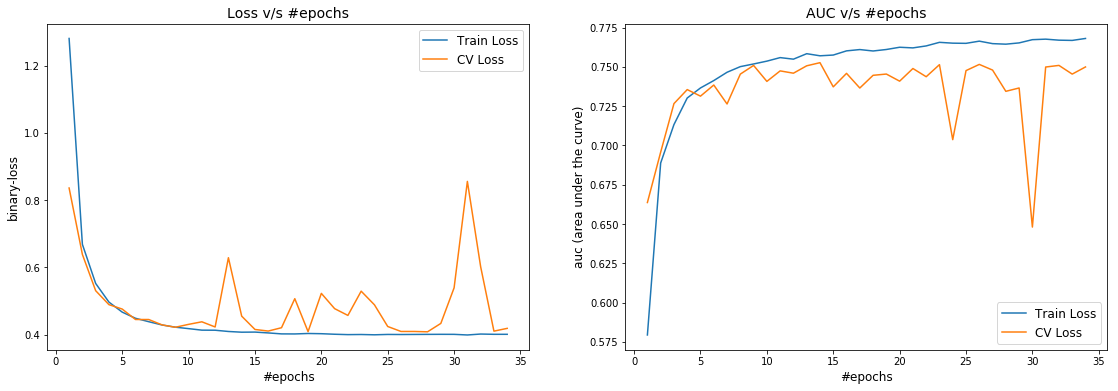

In [79]:
plot_history(history)

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# custom metric error during loading the model
print("\nLoadingg the model..")

if os.path.isfile(d+"Donor-Choose/Model_3.h5"):
    model3 = load_model(d+"Donor-Choose/Model_3.h5", custom_objects = {'auc': auc})
else:
    #move the saved model to dirve
    !cp "/content/Model_3.h5" "/content/drive/My Drive/Colab Notebooks/Dataset/Google_Word2Vec/Donor-Choose"
    model3 = load_model("Model_3.h5", custom_objects = {"auc":auc})
    
print("Evaluating model...")
print("For train data...")
score1 = model3.evaluate([encoded_essay_train, non_text_train], y_train, batch_size = 512)

print("For test data...")
score2 = model3.evaluate([encoded_essay_test, non_text_test], y_test, batch_size = 512)

print("\nFor training data: Loss = {:.4} and AUC = {:.4}\nFor test data: Loss = {:.4} and AUC = {:.4}"
      .format(score1[0], score1[1], score2[0], score2[1]))
table.add_row(["Model 3", round(score1[0], 4), round(score1[1], 4), round(score2[0], 4), round(score2[1], 4)])


Loadingg the model..
Evaluating model...
For train data...
87398/87398 [==============================] - 72s 824us/step
For test data...
10925/10925 [==============================] - 9s 819us/step

For training data: Loss = 0.4448 and AUC = 0.7748
For test data: Loss = 0.4268 and AUC = 0.7496


# 4. Conclusion

In [86]:
print(table)

+---------+------------+-----------+-----------+----------+
|  Model  | Train Loss | Train AUC | Test Loss | Test AUC |
+---------+------------+-----------+-----------+----------+
| Model 1 |   0.4431   |   0.7833  |   0.4835  |  0.7536  |
| Model 2 |   0.4178   |   0.7868  |   0.4641  |  0.7377  |
| Model 3 |   0.4448   |   0.7748  |   0.4268  |  0.7496  |
+---------+------------+-----------+-----------+----------+
